In [2]:
import tensorflow as tf

In [24]:
from pathlib import Path
import imghdr
import os

data_dir = r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/hops"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [25]:
train=r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/hops"
training_set = tf.keras.utils.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 318 files belonging to 3 classes.


In [26]:
classes = training_set.class_names
classes

['hops_downy', 'hops_healthy', 'hops_powdery']

In [27]:
total_batches = tf.data.experimental.cardinality(training_set).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size
train_dataset = training_set.take(train_size)
val_dataset = training_set.skip(train_size)
print(len(training_set))
print(len(train_dataset))
print(len(val_dataset))

20
16
4


In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # 6 classes
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [29]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential

preprocessing = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1)
])

train_ds = train_dataset.map(lambda x, y: (preprocessing(x), y))
val_ds = val_dataset.map(lambda x, y: (x / 255.0, y))


In [30]:
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.4, patience=3, min_lr=1e-6)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/10
16/16 [==============================] - 4s 153ms/step - loss: 0.9676 - categorical_accuracy: 0.5430 - val_loss: 0.4710 - val_categorical_accuracy: 0.8065 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - 2s 125ms/step - loss: 0.4896 - categorical_accuracy: 0.8320 - val_loss: 0.2785 - val_categorical_accuracy: 0.9355 - lr: 0.0010
Epoch 3/10
16/16 [==============================] - 3s 149ms/step - loss: 0.3017 - categorical_accuracy: 0.8906 - val_loss: 0.2893 - val_categorical_accuracy: 0.9032 - lr: 0.0010
Epoch 4/10
16/16 [==============================] - 2s 116ms/step - loss: 0.2520 - categorical_accuracy: 0.9258 - val_loss: 0.2037 - val_categorical_accuracy: 0.9516 - lr: 0.0010
Epoch 5/10
16/16 [==============================] - 2s 115ms/step - loss: 0.1416 - categorical_accuracy: 0.9688 - val_loss: 0.1757 - val_categorical_accuracy: 0.9516 - lr: 0.0010
Epoch 6/10
16/16 [==============================] - 2s 116ms/step - loss: 0.1126 - categorical_accuracy: 

In [32]:
train_loss,train_acc = model.evaluate(train_ds)

16/16 [==============================] - 1s 66ms/step - loss: 0.0292 - categorical_accuracy: 1.0000


In [33]:
val_loss,val__acc = model.evaluate(val_ds)

4/4 [==============================] - 1s 63ms/step - loss: 0.0336 - categorical_accuracy: 1.0000


In [35]:
model.save("trained_model_hops.keras")

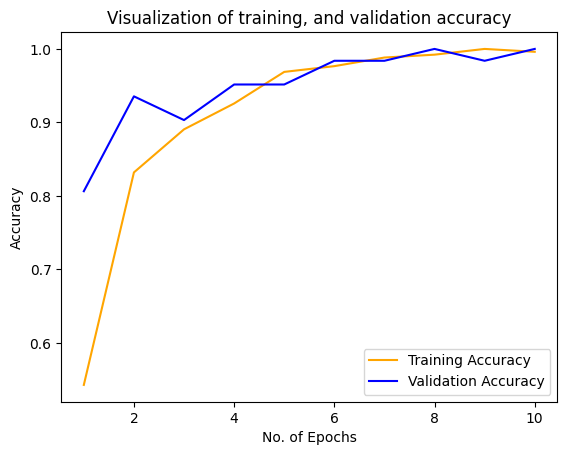

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

epochs=[i for i in range(1,11)]
plt.plot(epochs,history.history['categorical_accuracy'],color='orange',label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of training, and validation accuracy')
plt.legend()
plt.show()
